In [53]:
!pip install pyswarm colorama tabulate folium

In [54]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import folium
from colorama import Fore, Style, init
from IPython.display import display
from geopy.distance import geodesic
from datetime import datetime
from pyswarm import pso  # Particle Swarm Optimization

# Initialize colorama for nice console output
init()

# Print execution info
print(f"Execution Date and Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"User: kripa-sindhu-007\n")

Execution Date and Time: 2025-03-25 08:17:11
User: kripa-sindhu-007



In [55]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # Mass of the vehicle (kg)
    "wheel_radius": 0.2848,  # Wheel radius (meters)
    "transmission_ratio": 5.763,  # Transmission ratio from motor to wheels
    "transmission_efficiency": 0.95,  # Transmission efficiency coefficient
    "drive_efficiency": 0.85,  # Powertrain efficiency coefficient
    "a0": 125.73,  # Rolling resistance coefficient (N)
    "a1": 1.72,  # First-order drag coefficient (N/(m/s))
    "a2": 0.58,  # Second-order drag coefficient (N/(m/s)^2)
    "motor_min_torque": -50,  # Minimum motor torque (Nm)
    "motor_max_torque": 200,  # Maximum motor torque (Nm)
    "acceleration": 1.5,  # Standard acceleration (m/s²)
    "air_density": 1.225,  # Air density at sea level (kg/m^3)
    "gravity": 9.81,  # Gravity constant (m/s²)
    "battery_capacity": 60,  # kWh
    "initial_charge": 55,    # kWh (start with 90% charge)
    "min_charge": 5,         # kWh (minimum desired battery level)
    "cost_per_kwh": 0.20,    # $ per kWh for charging
    "green_zone_penalty": 10, # $ penalty for not using green zones when possible
    "running_cost_per_km": 0.04  # $ per km for maintenance, tire wear, etc.
}

In [56]:
def calculate_route_costs(path, graph, vehicle_params, charging_stations_used=None):
    """
    Standardized cost calculator for EV routing algorithms.
    Can be used by any routing algorithm to ensure consistent cost calculation.

    Parameters:
        path (list): List of node IDs representing the route
        graph (nx.Graph): Road network graph
        vehicle_params (dict): Vehicle parameters including battery capacity
        charging_stations_used (list, optional): List of charging stations visited on the route

    Returns:
        dict: All cost metrics and relevant statistics for the route
    """
    # Initialize metrics
    total_distance = 0
    total_time = 0
    total_energy = 0
    energy_cost = 0
    running_cost = 0
    green_zone_penalties = 0
    remaining_charge = vehicle_params["initial_charge"]

    # Calculate path metrics excluding charging operations
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        # Energy consumption
        edge_energy = graph[u][v]['energy']
        total_energy += edge_energy
        remaining_charge -= edge_energy

        # Energy cost (direct cost of electricity used)
        energy_cost += graph[u][v]['energy_cost']

        # Travel time
        total_time += graph[u][v]['travel_time']

        # Distance
        edge_distance = graph[u][v]['length']
        total_distance += edge_distance

        # Running cost (maintenance, tire wear, etc.)
        if "running_cost_per_km" in vehicle_params:
            running_cost += edge_distance * vehicle_params["running_cost_per_km"]
        else:
            # Calculate a vehicle-specific running cost if not provided
            mass_factor = vehicle_params["mass"] / 1500  # Normalize to standard vehicle
            efficiency_factor = 1 / (vehicle_params["drive_efficiency"] * vehicle_params["transmission_efficiency"])
            running_cost_per_km = 0.04 * mass_factor * efficiency_factor
            running_cost += edge_distance * running_cost_per_km

        # Green zone penalties
        if not graph[u][v].get('in_green_zone', True):
            green_zone_penalties += vehicle_params["green_zone_penalty"]

    # Initialize charging-related costs
    charging_cost = 0
    v2g_incentives = 0
    charging_time = 0

    # Process charging station visits if provided
    if charging_stations_used:
        # Simulate the route again, but this time process charging at specified stations
        current_charge = vehicle_params["initial_charge"]

        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]

            # Calculate energy used on this edge
            edge_energy = graph[u][v]['energy']
            current_charge -= edge_energy

            # If this is a charging station that we use, simulate charging
            if v in charging_stations_used:
                station_node = graph.nodes[v]

                # Estimate energy needed to reach destination from here
                energy_to_destination = 0
                remaining_path_index = path.index(v) + 1

                for j in range(remaining_path_index, len(path) - 1):
                    p, q = path[j], path[j + 1]
                    energy_to_destination += graph[p][q]['energy']

                # Add 20% safety buffer
                required_energy = energy_to_destination * 1.2

                # Calculate target charge level
                target_charge = min(
                    required_energy + vehicle_params["min_charge"],
                    vehicle_params["battery_capacity"] * 0.8  # Don't charge beyond 80% unless necessary
                )

                # If below target, charge the vehicle
                if current_charge < target_charge:
                    charge_amount = min(
                        target_charge - current_charge,
                        station_node.get('charging_capacity', 40)
                    )

                    current_charge += charge_amount

                    # Calculate charging time and cost
                    charge_rate = station_node.get('charging_rate', 7)  # kW
                    station_charging_time = charge_amount / charge_rate  # hours
                    charging_time += station_charging_time
                    charging_cost += charge_amount * vehicle_params["cost_per_kwh"]

                # If V2G is enabled and we have excess energy, give some back
                elif station_node.get('v2g_enabled', False) and current_charge > (required_energy + 15):
                    # Only give back energy if we have excess (15 kWh buffer)
                    excess_energy = current_charge - (required_energy + 15)

                    # Realistic V2G amounts (typically 5-10 kWh maximum per station)
                    v2g_amount = min(
                        excess_energy * 0.7,  # Use up to 70% of excess energy
                        8,  # Cap at 8 kWh per station
                        station_node.get('v2g_capacity', 10)
                    )

                    if v2g_amount > 3:  # Only if significant (>3 kWh)
                        current_charge -= v2g_amount

                        # Realistic incentive rates (typically 80-120% of charging cost)
                        incentive_rate = station_node.get('incentive_rate', 1.1 * vehicle_params["cost_per_kwh"])
                        v2g_incentives += v2g_amount * incentive_rate

    # Calculate final total cost
    total_cost = energy_cost + running_cost + charging_cost - v2g_incentives + green_zone_penalties

    # Create comprehensive metrics dictionary
    metrics = {
        "distance": total_distance,
        "time": total_time + charging_time,  # Include charging time in total
        "energy": total_energy,
        "energy_cost": energy_cost,
        "running_cost": running_cost,
        "charging_cost": charging_cost,
        "v2g_incentives": v2g_incentives,
        "green_zone_penalties": green_zone_penalties,
        "total_cost": total_cost,
        "remaining_charge": remaining_charge,
        "charging_stations_visited": charging_stations_used if charging_stations_used else [],
        "charging_time": charging_time
    }

    # Add warning if battery might deplete
    if remaining_charge < vehicle_params["min_charge"]:
        metrics["warning"] = "Battery might deplete before reaching destination"

    return metrics

In [57]:
def compute_section_energy(length, speed, grade, vehicle_params, acceleration=0):
    """
    Compute energy consumption for a road section based on the De Nunzio model

    Parameters:
        length (float): Road section length in meters
        speed (float): Speed in m/s
        grade (float): Road grade (slope) as a decimal (e.g., 0.03 for 3%)
        vehicle_params (dict): Dictionary of vehicle parameters
        acceleration (float): Acceleration in m/s²

    Returns:
        float: Energy consumption in kWh
    """
    # Avoid division by zero
    if speed <= 0:
        return 0

    # Calculate forces
    rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
    slope_force = vehicle_params["mass"] * vehicle_params["gravity"] * grade
    inertial_force = vehicle_params["mass"] * acceleration

    # Total force at wheels
    total_force = rolling_force + slope_force + inertial_force

    # Motor torque and power calculation
    wheel_radius = vehicle_params["wheel_radius"]
    transmission_ratio = vehicle_params["transmission_ratio"]
    transmission_efficiency = vehicle_params["transmission_efficiency"]

    if total_force >= 0:
        # Traction phase (positive force)
        motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
    else:
        # Regenerative braking (negative force)
        motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio

    # Ensure motor torque is within limits
    motor_torque = max(vehicle_params["motor_min_torque"], min(vehicle_params["motor_max_torque"], motor_torque))

    # Calculate motor speed and power
    motor_speed = speed * transmission_ratio / wheel_radius
    motor_power = motor_torque * motor_speed

    # Battery power demand with efficiency consideration
    drive_efficiency = vehicle_params["drive_efficiency"]
    if motor_power >= 0:
        # Power consumption
        battery_power = motor_power / drive_efficiency
    else:
        # Regenerative braking
        battery_power = motor_power * drive_efficiency

    # Calculate travel time and energy
    travel_time = length / speed  # seconds
    energy_joules = battery_power * travel_time  # Joules
    energy_kwh = energy_joules / 3600000  # Convert to kWh

    return energy_kwh

In [58]:
def generate_road_network(num_nodes=400, num_edges=1200, seed=42,
                          num_charging_stations=20, num_green_zones=5):
    """
    Generate a synthetic road network with charging stations and green zones.

    Parameters:
        num_nodes (int): Number of nodes (intersections)
        num_edges (int): Number of edges (roads)
        seed (int): Random seed for reproducibility
        num_charging_stations (int): Number of charging stations to add
        num_green_zones (int): Number of green zones in the city

    Returns:
        nx.Graph: NetworkX graph representing the road network
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Create a grid-like graph to represent an urban environment
    grid_size = int(np.sqrt(num_nodes))
    road_network = nx.grid_2d_graph(grid_size, grid_size)

    # Convert the grid to a proper road network
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic coordinates to each node
    # Metro city is roughly 30km x 30km
    city_size = 30000  # 30 km in meters
    pos = {}
    for i in range(road_network.number_of_nodes()):
        row = i // grid_size
        col = i % grid_size
        # Add some randomness to make it look more natural
        jitter = np.random.normal(0, 200, 2)  # 200m standard deviation
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]

    # Set node positions as attributes
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add charging stations to random nodes
    charging_station_nodes = random.sample(list(road_network.nodes()), num_charging_stations)
    for node in road_network.nodes():
        if node in charging_station_nodes:
            road_network.nodes[node]['charging_station'] = True
            road_network.nodes[node]['charging_capacity'] = np.random.uniform(50, 200)  # kWh available
            road_network.nodes[node]['charging_rate'] = np.random.uniform(50, 150)  # kW (charging speed)
            road_network.nodes[node]['v2g_enabled'] = True  # Vehicle-to-Grid capability
            road_network.nodes[node]['incentive_rate'] = .15  # $ per kWh for V2G
        else:
            road_network.nodes[node]['charging_station'] = False

    # Define green zones (circular areas in the city)
    green_zones = []
    for _ in range(num_green_zones):
        # Create a random circular zone
        center_x = np.random.uniform(0, city_size)
        center_y = np.random.uniform(0, city_size)
        radius = np.random.uniform(1000, 3000)  # 1-3 km radius
        green_zones.append({
            'center': (center_x, center_y),
            'radius': radius,
            'penalty': np.random.uniform(5, 15)  # $ penalty for not using green zones
        })

    # Store green zones as a graph attribute
    road_network.graph['green_zones'] = green_zones

    # Add random edges to reach the desired number of edges
    existing_edges = len(road_network.edges())
    edges_to_add = max(0, num_edges - existing_edges)

    # Add more complex road structure with additional connections
    attempts = 0
    while len(road_network.edges()) < num_edges and attempts < edges_to_add * 3:
        attempts += 1
        # Select random nodes for a new edge
        node1, node2 = random.sample(list(road_network.nodes()), 2)

        # Skip if edge already exists
        if road_network.has_edge(node1, node2):
            continue

        # Skip if distance is too large (unrealistic road connection)
        pos1, pos2 = pos[node1], pos[node2]
        dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
        if dist > city_size / 5:  # Don't connect nodes that are too far apart
            continue

        # Add edge
        road_network.add_edge(node1, node2)

    # Add road properties to edges including energy calculation
    for u, v in road_network.edges():
        # Calculate real distance based on positions
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)

        # Metropolitan area has more diverse roads
        # Assign attributes based on De Nunzio model requirements
        road_network[u][v]['length'] = distance  # meters
        road_network[u][v]['traffic_density'] = np.random.normal(0.7, 0.2)  # vehicles/km

        # More diverse speed limits: local streets, arterials, highways
        road_network[u][v]['speed_limit'] = np.random.choice(
            [30, 40, 50, 60, 80],
            p=[0.2, 0.3, 0.3, 0.15, 0.05]
        ) * (1000/3600)  # km/h to m/s

        # More varied grades (hills, etc.)
        road_network[u][v]['grade'] = 0 # np.random.uniform(-0.05, 0.05)  # slope, as a percentage

        # Calculate travel time based on speed and length
        road_network[u][v]['travel_time'] = road_network[u][v]['length'] / road_network[u][v]['speed_limit']

        # Calculate energy consumption for this edge
        energy = compute_section_energy(
            road_network[u][v]['length'],
            road_network[u][v]['speed_limit'],
            road_network[u][v]['grade'],
            VEHICLE_PARAMETERS
        )

        # Store energy as an edge attribute
        road_network[u][v]['energy'] = energy

        # Add monetary cost (assume $0.20 per kWh, but only for positive energy)
        road_network[u][v]['energy_cost'] = max(0, energy) * 0.20  # $ per kWh

        # Add absolute energy value as alternative weight to avoid negative cycles
        road_network[u][v]['abs_energy'] = abs(energy)

        # Check if this edge passes through any green zone
        edge_midpoint = ((pos_u[0] + pos_v[0])/2, (pos_u[1] + pos_v[1])/2)
        in_green_zone = False
        for zone in green_zones:
            dist_to_center = np.sqrt((edge_midpoint[0] - zone['center'][0])**2 +
                                     (edge_midpoint[1] - zone['center'][1])**2)
            if dist_to_center <= zone['radius']:
                in_green_zone = True
                break

        road_network[u][v]['in_green_zone'] = in_green_zone

    return road_network

In [59]:
def heuristic_routing_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Heuristic routing algorithm combining Dijkstra for initial path and PSO for optimization.
    Considers charging stations, green zones, and energy optimization.
    Only visits charging stations that are on or close to the initial path.

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters including battery capacity

    Returns:
        tuple: (path, energy, metrics) where:
               path is a list of nodes
               energy is the total energy consumed
               metrics includes all relevant metrics (cost, penalties, incentives, etc.)
    """
    # First, use Dijkstra to find an initial path
    initial_path = nx.dijkstra_path(graph, source, target, weight='abs_energy')

    # Calculate initial path metrics using standardized calculator
    initial_metrics = calculate_route_costs(initial_path, graph, vehicle_params)
    initial_energy = initial_metrics["energy"]

    # Check if we need charging based on initial path energy consumption
    needs_charging = initial_energy > (vehicle_params["initial_charge"] - vehicle_params["min_charge"])

    # If we don't need charging, return the initial path
    if not needs_charging:
        return initial_path, initial_energy, initial_metrics

    # Define the maximum allowed detour distance (as a percentage of total path length)
    MAX_DETOUR_PERCENTAGE = 0.15  # 15%
    max_detour_distance = initial_metrics["distance"] * MAX_DETOUR_PERCENTAGE

    # Find all charging stations in the graph
    all_charging_stations = [node for node in graph.nodes() if graph.nodes[node].get('charging_station', False)]

    # Filter charging stations that are on or close to the initial path
    charging_stations = []
    for station in all_charging_stations:
        # Skip if the station is already on our path
        if station in initial_path:
            charging_stations.append(station)
            continue

        # Check distance to the nearest path node
        min_distance_to_path = float('inf')
        for path_node in initial_path:
            try:
                distance = nx.shortest_path_length(graph, path_node, station, weight='length')
                if distance < min_distance_to_path:
                    min_distance_to_path = distance
            except nx.NetworkXNoPath:
                continue

        # Add station if it's close enough to the path
        if min_distance_to_path <= max_detour_distance:
            charging_stations.append(station)

    # If no charging stations are close to the path, return the initial path (with warning)
    if not charging_stations:
        initial_metrics["warning"] = "Battery might deplete before reaching destination"
        return initial_path, initial_energy, initial_metrics

    # Define our optimization function
    def objective_function(x):
        """
        Objective function for PSO optimization.
        x is a binary array where 1 indicates a charging station to visit.
        """
        # Convert binary decisions to list of charging stations to visit
        visit_stations = [station for i, station in enumerate(charging_stations) if x[i] > 0.5]

        if not visit_stations and needs_charging:
            # If we need charging but no stations selected, return high penalty
            return 1e6

        # Try to construct a path that visits the selected charging stations
        try:
            # Sort charging stations based on their position along the initial path
            sorted_stations = []
            for station in visit_stations:
                if station in initial_path:
                    # For stations on the path, use their position in the initial path
                    pos = initial_path.index(station)
                else:
                    # For stations off the path, find the closest path node
                    min_dist = float('inf')
                    closest_pos = 0
                    for i, path_node in enumerate(initial_path):
                        try:
                            dist = nx.shortest_path_length(graph, path_node, station, weight='length')
                            if dist < min_dist:
                                min_dist = dist
                                closest_pos = i
                        except nx.NetworkXNoPath:
                            continue
                    pos = closest_pos

                sorted_stations.append((station, pos))

            # Sort by position
            sorted_stations.sort(key=lambda x: x[1])
            visit_stations = [s[0] for s in sorted_stations]

            # Construct complete path
            complete_path = [source]
            current = source

            # Add each charging station to the path
            for station in visit_stations:
                if current != station:  # Skip if we're already at this station
                    # Find path to this charging station
                    sub_path = nx.dijkstra_path(graph, current, station, weight='abs_energy')
                    # Skip the first node as it's already in the path
                    sub_path = sub_path[1:]
                    # Add to complete path
                    complete_path.extend(sub_path)
                    current = station

            # Add path to destination if we're not already there
            if current != target:
                final_sub_path = nx.dijkstra_path(graph, current, target, weight='abs_energy')
                # Skip the first node as it's already in the path
                final_sub_path = final_sub_path[1:]
                # Add to complete path
                complete_path.extend(final_sub_path)

            # Calculate metrics for this path using standardized calculator
            metrics = calculate_route_costs(complete_path, graph, vehicle_params, visit_stations)

            # Additional penalty for too many stops
            num_stations_penalty = len(visit_stations) * 5  # $5 penalty per stop

            # Add penalty for excessive detours
            path_efficiency_penalty = 0
            if metrics["distance"] > initial_metrics["distance"] * 1.3:  # More than 30% longer
                path_efficiency_penalty = (metrics["distance"] - initial_metrics["distance"]) * 0.1

            # Check if battery would deplete
            if metrics.get("warning"):
                return 1e6  # Battery would deplete

            # Return total cost with additional penalties
            return metrics["total_cost"] + num_stations_penalty + path_efficiency_penalty

        except nx.NetworkXNoPath:
            # If we can't find a path with these charging stations
            return 1e6  # Large penalty

    # Only run optimization if there are charging stations
    if charging_stations:
        # Use Particle Swarm Optimization to find the best charging stations to visit
        lb = np.zeros(len(charging_stations))  # Lower bound (0 = don't visit)
        ub = np.ones(len(charging_stations))   # Upper bound (1 = visit)

        # Run PSO with constraints
        xopt, _ = pso(objective_function, lb, ub, swarmsize=15, maxiter=30, debug=False)

        # Convert binary decisions to list of charging stations to visit
        visit_stations = [station for i, station in enumerate(charging_stations) if xopt[i] > 0.5]

        # Construct the final path with the optimized charging stations
        if visit_stations:
            # Sort charging stations based on their position along the initial path
            sorted_stations = []
            for station in visit_stations:
                if station in initial_path:
                    pos = initial_path.index(station)
                else:
                    min_dist = float('inf')
                    closest_pos = 0
                    for i, path_node in enumerate(initial_path):
                        try:
                            dist = nx.shortest_path_length(graph, path_node, station, weight='length')
                            if dist < min_dist:
                                min_dist = dist
                                closest_pos = i
                        except nx.NetworkXNoPath:
                            continue
                    pos = closest_pos

                sorted_stations.append((station, pos))

            # Sort by position
            sorted_stations.sort(key=lambda x: x[1])
            visit_stations = [s[0] for s in sorted_stations]

            # Construct complete path
            optimized_path = [source]
            current = source

            # Add each charging station to the path
            for station in visit_stations:
                if current != station:  # Skip if we're already at this station
                    # Find path to this charging station
                    sub_path = nx.dijkstra_path(graph, current, station, weight='abs_energy')
                    # Skip the first node as it's already in the path
                    sub_path = sub_path[1:]
                    # Add to complete path
                    optimized_path.extend(sub_path)
                    current = station

            # Add path to destination if we're not already there
            if current != target:
                final_sub_path = nx.dijkstra_path(graph, current, target, weight='abs_energy')
                # Skip the first node as it's already in the path
                final_sub_path = final_sub_path[1:]
                # Add to complete path
                optimized_path.extend(final_sub_path)

            # Calculate final metrics using standardized calculator
            final_metrics = calculate_route_costs(optimized_path, graph, vehicle_params, visit_stations)

            return optimized_path, final_metrics["energy"], final_metrics

    # If no charging stations or optimization fails, return the initial path
    initial_metrics["warning"] = "Battery might deplete before reaching destination" if needs_charging else None
    return initial_path, initial_energy, initial_metrics

In [60]:
def eco_routing_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Implementation of eco-routing using NetworkX's built-in Bellman-Ford algorithm
    with energy consumption as the weight.

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        tuple: (path, energy, metrics) where path is a list of nodes,
               energy is the total energy consumed, and metrics contains detailed cost info
    """
    try:
        # Try to use energy as the weight directly
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="energy")
    except nx.NetworkXUnbounded:
        # If there's a negative cycle, use absolute energy values to find a reasonable path
        print("Warning: Negative energy cycle detected. Using absolute energy values.")
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="abs_energy")

    # Use standardized cost calculator for consistent metrics
    metrics = calculate_route_costs(path, graph, vehicle_params)

    # Return path, energy, and all metrics
    return path, metrics["energy"], metrics

In [61]:
def shortest_path_distance(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the shortest path based on distance

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        tuple: (path, energy, metrics) where path is a list of nodes,
               energy is the total energy consumed, and metrics contains detailed cost info
    """
    try:
        # Use Dijkstra algorithm with length as weight
        path = nx.dijkstra_path(graph, source, target, weight='length')

        # Use standardized cost calculator for consistent metrics
        metrics = calculate_route_costs(path, graph, vehicle_params)

        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        # If no path exists
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }

In [62]:
def fastest_path_time(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the fastest path based on travel time

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        tuple: (path, energy, metrics) where path is a list of nodes,
               energy is the total energy consumed, and metrics contains detailed cost info
    """
    try:
        # Use Dijkstra algorithm with travel_time as weight
        path = nx.dijkstra_path(graph, source, target, weight='travel_time')

        # Use standardized cost calculator for consistent metrics
        metrics = calculate_route_costs(path, graph, vehicle_params)

        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        # If no path exists
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }

In [63]:
def select_random_od_pairs(graph, num_pairs=20, min_distance=3000):
    """
    Select random origin-destination pairs with a minimum distance

    Parameters:
        graph (nx.Graph): Road network graph
        num_pairs (int): Number of O-D pairs to select
        min_distance (float): Minimum distance between origin and destination in meters

    Returns:
        list: List of (origin, destination) pairs
    """
    od_pairs = []
    nodes = list(graph.nodes())
    total_attempts = 0
    max_attempts = num_pairs * 10  # Limit attempts to avoid infinite loops

    print(f"Selecting {num_pairs} O-D pairs with minimum distance of {min_distance} meters...")

    while len(od_pairs) < num_pairs and total_attempts < max_attempts:
        total_attempts += 1

        # Progress reporting
        if total_attempts % 1000 == 0:
            print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found ({total_attempts} attempts)")

        origin, destination = random.sample(nodes, 2)

        # Skip if we've already selected this pair
        if (origin, destination) in od_pairs or (destination, origin) in od_pairs:
            continue

        # Check if there's a path between them
        try:
            # Try to find a path
            path = nx.shortest_path(graph, origin, destination)

            # Calculate the distance of this path
            path_distance = 0
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                path_distance += graph[u][v]['length']

            # If distance is sufficient, add the pair
            if path_distance >= min_distance:
                od_pairs.append((origin, destination))
                if len(od_pairs) % 5 == 0:
                    print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found")
        except nx.NetworkXNoPath:
            # No path between these nodes
            continue

    if len(od_pairs) < num_pairs:
        print(f"Warning: Only {len(od_pairs)} O-D pairs found after {total_attempts} attempts.")
    else:
        print(f"Successfully selected {num_pairs} O-D pairs.")

    return od_pairs

In [64]:
def visualize_paths(graph, paths_dict, figsize=(12, 10)):
    """
    Visualize multiple paths on the same graph.

    Parameters:
        graph (nx.Graph): Road network graph
        paths_dict (dict): Dictionary mapping names to paths
        figsize (tuple): Figure size
    """
    plt.figure(figsize=figsize)

    # Get node positions
    pos = nx.get_node_attributes(graph, 'pos')

    # Define color map for different paths
    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']

    # Draw the network
    nx.draw_networkx_edges(graph, pos, alpha=0.1, width=1)

    # Draw charging stations
    charging_stations = [node for node in graph.nodes() if graph.nodes[node].get('charging_station', False)]
    nx.draw_networkx_nodes(graph, pos, nodelist=charging_stations, node_color='green', node_size=50, alpha=0.8)

    # Draw each path
    for i, (name, path) in enumerate(paths_dict.items()):
        # Skip empty paths
        if not path:
            continue

        # Draw edges in the path
        path_edges = [(path[j], path[j+1]) for j in range(len(path)-1)]
        color = colors[i % len(colors)]
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color=color, width=2.5)

        # Highlight source and target
        source, target = path[0], path[-1]
        nx.draw_networkx_nodes(graph, pos, nodelist=[source, target], node_color=color, node_size=100)

        # Mark charging stations used on this path
        if isinstance(path, tuple) and len(path) > 2:
            charging_used = path[2].get('charging_stations_visited', [])
            if charging_used:
                nx.draw_networkx_nodes(graph, pos, nodelist=charging_used,
                                     node_color=color, node_shape='s', node_size=80)

    # Create legend
    legend_elements = []
    from matplotlib.lines import Line2D
    for i, name in enumerate(paths_dict.keys()):
        if i < len(colors) and paths_dict[name]:
            legend_elements.append(Line2D([0], [0], color=colors[i], lw=2, label=name))

    # Add charging station to legend
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                                  markersize=10, label='Charging Station'))

    plt.legend(handles=legend_elements, loc='best')
    plt.title('Path Comparison')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [65]:
def compare_path_metrics(metrics_dict):
    """
    Compare metrics from different routing algorithms.

    Parameters:
        metrics_dict (dict): Dictionary mapping algorithm names to metrics dictionaries

    Returns:
        pd.DataFrame: DataFrame with comparison results
    """
    comparison = {}

    # Extract relevant metrics for each algorithm
    for algo_name, metrics in metrics_dict.items():
        if not metrics:
            continue

        comparison[algo_name] = {
            'Distance (km)': round(metrics.get('distance', float('inf')) / 1000, 2),
            'Time (min)': round(metrics.get('time', float('inf')) / 60, 2),
            'Energy (kWh)': round(metrics.get('energy', float('inf')), 2),
            'Energy Cost ($)': round(metrics.get('energy_cost', float('inf')), 2),
            'Running Cost ($)': round(metrics.get('running_cost', 0), 2),
            'Charging Cost ($)': round(metrics.get('charging_cost', 0), 2),
            'V2G Incentives ($)': round(metrics.get('v2g_incentives', 0), 2),
            'Green Zone Penalties ($)': round(metrics.get('green_zone_penalties', 0), 2),
            'Total Cost ($)': round(metrics.get('total_cost', float('inf')), 2),
            'Remaining Charge (kWh)': round(metrics.get('remaining_charge', 0), 2),
            'Charging Stations': len(metrics.get('charging_stations_visited', []))
        }

    # Convert to DataFrame for pretty display
    df = pd.DataFrame.from_dict(comparison, orient='index')

    # Apply color highlighting
    def highlight_min(s):
        is_min = s == s.min()
        return ['background-color: lightgreen' if v else '' for v in is_min]

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: lightgreen' if v else '' for v in is_max]

    # Highlight best values (min or max depending on metric)
    styled_df = df.style.apply(highlight_min, subset=['Distance (km)', 'Time (min)', 'Energy (kWh)',
                                                    'Energy Cost ($)', 'Running Cost ($)',
                                                    'Charging Cost ($)', 'Green Zone Penalties ($)',
                                                    'Total Cost ($)'])

    styled_df = styled_df.apply(highlight_max, subset=['V2G Incentives ($)', 'Remaining Charge (kWh)'])

    return styled_df

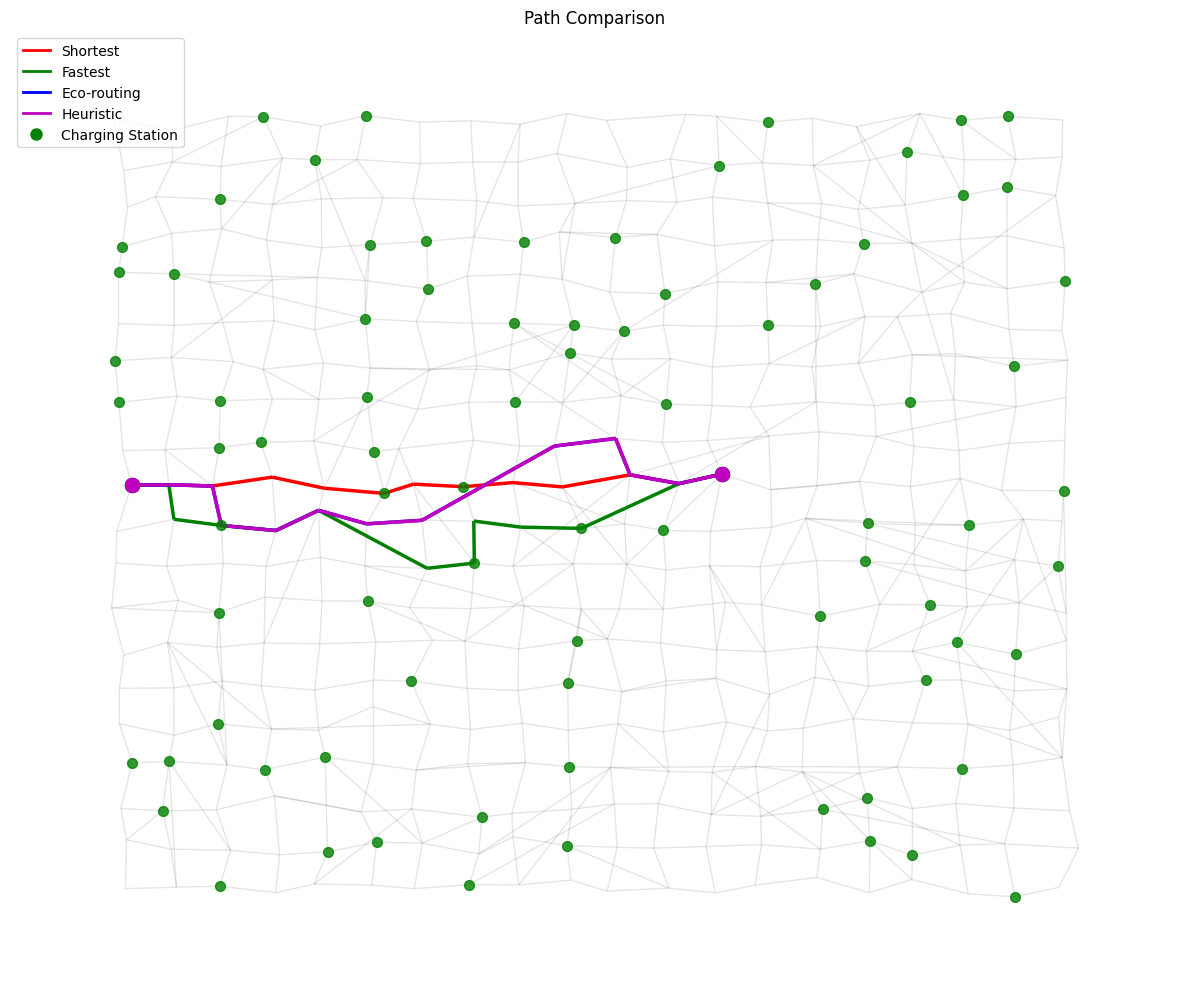

,Distance (km),Time (min),Energy (kWh),Energy Cost ($),Running Cost ($),Charging Cost ($),V2G Incentives ($),Green Zone Penalties ($),Total Cost ($),Remaining Charge (kWh),Charging Stations
Shortest,19.160000,28.010000,1.570000,0.310000,766.560000,0,0,120,886.880000,53.430000,0
Fastest,23.150000,26.460000,2.390000,0.480000,926.110000,0,0,110,1036.590000,52.610000,0
Eco-routing,22.480000,39.180000,1.570000,0.310000,899.360000,0,0,100,999.670000,53.430000,0
Heuristic,22.480000,39.180000,1.570000,0.310000,899.360000,0,0,100,999.670000,53.430000,0


In [66]:
# Generate a road network
road_network = generate_road_network(num_nodes=400, num_edges=1200,
                                    num_charging_stations=80, num_green_zones=20, seed=42)

# Select a source and destination node
source = 10
target = 250

# Run all routing algorithms with standardized cost calculation
shortest_path, shortest_energy, shortest_metrics = shortest_path_distance(road_network, source, target)
fastest_path, fastest_energy, fastest_metrics = fastest_path_time(road_network, source, target)
eco_path, eco_energy, eco_metrics = eco_routing_algorithm(road_network, source, target)
heuristic_path, heuristic_energy, heuristic_metrics = heuristic_routing_algorithm(road_network, source, target)

# Compare different paths
paths_dict = {
    'Shortest': shortest_path,
    'Fastest': fastest_path,
    'Eco-routing': eco_path,
    'Heuristic': heuristic_path
}

# Visualize the paths
visualize_paths(road_network, paths_dict)

# Compare metrics
metrics_dict = {
    'Shortest': shortest_metrics,
    'Fastest': fastest_metrics,
    'Eco-routing': eco_metrics,
    'Heuristic': heuristic_metrics
}

# Display comparison table
compare_path_metrics(metrics_dict)

In [67]:
def run_batch_comparison(graph, od_pairs, algorithms, vehicle_params=VEHICLE_PARAMETERS):
    """
    Run a batch comparison of multiple routing algorithms across many O-D pairs.

    Parameters:
        graph (nx.Graph): Road network graph
        od_pairs (list): List of (origin, destination) tuples
        algorithms (dict): Dictionary mapping algorithm names to functions
        vehicle_params (dict): Vehicle parameters

    Returns:
        pd.DataFrame: DataFrame with results for all O-D pairs and algorithms
    """
    # Initialize results storage
    results = []

    # Track progress
    total_pairs = len(od_pairs)
    print(f"Starting batch comparison of {len(algorithms)} algorithms on {total_pairs} O-D pairs...")
    start_time = datetime.now()

    # Process each O-D pair
    for i, (origin, destination) in enumerate(od_pairs):
        # Show progress every 100 pairs or at specific percentages
        if (i+1) % 100 == 0 or (i+1) in [1, 10, 50, total_pairs]:
            elapsed = (datetime.now() - start_time).total_seconds()
            est_total = elapsed / (i+1) * total_pairs
            print(f"Progress: {i+1}/{total_pairs} pairs ({((i+1)/total_pairs*100):.1f}%) - "
                  f"Elapsed: {elapsed:.1f}s, Estimated Total: {est_total:.1f}s")

        # Skip pairs that are too close (could cause issues with some algorithms)
        try:
            distance = nx.shortest_path_length(graph, origin, destination, weight='length')
            if distance < 1000:  # Skip if less than 1km
                continue
        except nx.NetworkXNoPath:
            continue

        # Run each algorithm on this O-D pair
        pair_results = {'origin': origin, 'destination': destination, 'pair_id': i}

        for algo_name, algo_func in algorithms.items():
            try:
                # Run algorithm with timeout protection to avoid hanging on complex paths
                path, energy, metrics = algo_func(graph, origin, destination, vehicle_params)

                # Record key metrics
                pair_results[f'{algo_name}_success'] = True
                pair_results[f'{algo_name}_path_length'] = len(path) if path else 0
                pair_results[f'{algo_name}_distance'] = metrics.get('distance', float('inf'))
                pair_results[f'{algo_name}_time'] = metrics.get('time', float('inf'))
                pair_results[f'{algo_name}_energy'] = metrics.get('energy', float('inf'))
                pair_results[f'{algo_name}_energy_cost'] = metrics.get('energy_cost', float('inf'))
                pair_results[f'{algo_name}_running_cost'] = metrics.get('running_cost', 0)
                pair_results[f'{algo_name}_charging_cost'] = metrics.get('charging_cost', 0)
                pair_results[f'{algo_name}_v2g_incentives'] = metrics.get('v2g_incentives', 0)
                pair_results[f'{algo_name}_green_penalties'] = metrics.get('green_zone_penalties', 0)
                pair_results[f'{algo_name}_total_cost'] = metrics.get('total_cost', float('inf'))
                pair_results[f'{algo_name}_remaining_charge'] = metrics.get('remaining_charge', 0)
                pair_results[f'{algo_name}_num_charging'] = len(metrics.get('charging_stations_visited', []))
                pair_results[f'{algo_name}_warning'] = metrics.get('warning', '')

            except Exception as e:
                # Record failure
                pair_results[f'{algo_name}_success'] = False
                pair_results[f'{algo_name}_error'] = str(e)

        # Add to results
        results.append(pair_results)

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    print(f"Batch comparison completed in {(datetime.now() - start_time).total_seconds():.1f} seconds.")
    print(f"Processed {len(results)} valid O-D pairs.")

    return results_df

In [68]:
def save_comparison_results(results_df, filename='routing_comparison_results'):
    """
    Save comparison results to multiple formats for later analysis.

    Parameters:
        results_df (pd.DataFrame): DataFrame with comparison results
        filename (str): Base filename (without extension)

    Returns:
        str: Path to the saved CSV file
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = f"{filename}_{timestamp}.csv"
    # excel_path = f"{filename}_{timestamp}.xlsx"
    # pickle_path = f"{filename}_{timestamp}.pkl"

    # Save as CSV (most universal)
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    # # Save as Excel (better formatting)
    # try:
    #     results_df.to_excel(excel_path, index=False)
    #     print(f"Results saved to {excel_path}")
    # except Exception as e:
    #     print(f"Could not save as Excel: {e}")

    # # Save as pickle (preserves all data types, but Python-specific)
    # try:
    #     results_df.to_pickle(pickle_path)
    #     print(f"Results saved to {pickle_path}")
    # except Exception as e:
    #     print(f"Could not save as pickle: {e}")

    return csv_path

In [69]:
def analyze_comparison_results(results_df, algorithms):
    """
    Analyze and visualize comparison results.

    Parameters:
        results_df (pd.DataFrame): DataFrame with comparison results
        algorithms (list): List of algorithm names

    Returns:
        pd.DataFrame: Summary statistics
    """
    print(f"Analyzing results for {len(results_df)} origin-destination pairs...")

    # Filter out pairs where any algorithm failed
    valid_results = results_df.copy()
    for algo in algorithms:
        valid_results = valid_results[valid_results[f'{algo}_success'] == True]

    print(f"Found {len(valid_results)} O-D pairs with valid results for all algorithms.")

    # Calculate summary statistics
    summary = {}
    metrics = ['distance', 'time', 'energy', 'energy_cost', 'running_cost',
               'charging_cost', 'v2g_incentives', 'green_penalties', 'total_cost',
               'remaining_charge', 'num_charging']

    for algo in algorithms:
        summary[algo] = {}
        for metric in metrics:
            col = f'{algo}_{metric}'
            if col in valid_results.columns:
                summary[algo][metric] = {
                    'mean': valid_results[col].mean(),
                    'median': valid_results[col].median(),
                    'min': valid_results[col].min(),
                    'max': valid_results[col].max(),
                    'std': valid_results[col].std()
                }

    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Algorithm': [],
        'Metric': [],
        'Mean': [],
        'Median': [],
        'Min': [],
        'Max': [],
        'Std Dev': []
    })

    for algo in algorithms:
        for metric in metrics:
            if metric in summary[algo]:
                summary_df = pd.concat([summary_df, pd.DataFrame({
                    'Algorithm': [algo],
                    'Metric': [metric],
                    'Mean': [summary[algo][metric]['mean']],
                    'Median': [summary[algo][metric]['median']],
                    'Min': [summary[algo][metric]['min']],
                    'Max': [summary[algo][metric]['max']],
                    'Std Dev': [summary[algo][metric]['std']]
                })], ignore_index=True)

    # Calculate relative performance (normalized to Shortest path)
    relative_perf = {}
    baseline_algo = 'Shortest'  # Use shortest path as baseline

    for metric in ['distance', 'time', 'energy', 'total_cost']:
        relative_perf[metric] = {}
        baseline_mean = valid_results[f'{baseline_algo}_{metric}'].mean()

        for algo in algorithms:
            if algo != baseline_algo:
                algo_mean = valid_results[f'{algo}_{metric}'].mean()
                relative_perf[metric][algo] = ((algo_mean / baseline_mean) - 1) * 100  # percent change

    # Create visualizations
    # 1. Bar chart of mean total cost by algorithm
    plt.figure(figsize=(12, 6))
    algo_costs = [valid_results[f'{algo}_total_cost'].mean() for algo in algorithms]
    plt.bar(algorithms, algo_costs, color=['blue', 'orange', 'green', 'red'])
    plt.title('Mean Total Cost by Algorithm')
    plt.ylabel('Cost ($)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, cost in enumerate(algo_costs):
        plt.text(i, cost + 0.5, f'${cost:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

    # 2. Comparative bar chart for multiple metrics
    metrics_to_plot = ['distance', 'time', 'energy', 'total_cost']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        metric_values = {}
        for algo in algorithms:
            metric_values[algo] = valid_results[f'{algo}_{metric}'].mean()

        ax = axes[i]
        ax.bar(list(metric_values.keys()), list(metric_values.values()))

        # Format y-axis based on metric
        if metric == 'distance':
            ax.set_title('Mean Distance (m)')
            # Convert to km for display
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'{v/1000:.2f} km', ha='center')
        elif metric == 'time':
            ax.set_title('Mean Time (seconds)')
            # Convert to minutes for display
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'{v/60:.2f} min', ha='center')
        elif metric == 'energy':
            ax.set_title('Mean Energy (kWh)')
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'{v:.2f} kWh', ha='center')
        else:
            ax.set_title(f'Mean {metric.title().replace("_", " ")}')
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'${v:.2f}', ha='center')

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 3. Table of relative performance compared to shortest path
    relative_df = pd.DataFrame(columns=['Metric'] + [algo for algo in algorithms if algo != baseline_algo])

    for metric in relative_perf:
        row = {'Metric': metric.title()}
        for algo in algorithms:
            if algo != baseline_algo:
                row[algo] = f"{relative_perf[metric][algo]:.2f}%"
        relative_df = pd.concat([relative_df, pd.DataFrame([row])], ignore_index=True)

    # print("\nRelative Performance (% change from Shortest Path):")
    # display(relative_df)

    # Return detailed summary
    return summary_df

In [70]:
def run_comprehensive_evaluation(num_od_pairs=2000, min_distance=3000, save_results=True):
    """
    Run a comprehensive evaluation of all routing algorithms on a large number of O-D pairs.

    Parameters:
        num_od_pairs (int): Number of origin-destination pairs to test
        min_distance (float): Minimum distance between origin and destination
        save_results (bool): Whether to save results to files

    Returns:
        tuple: (results_df, summary_df) with raw results and summary statistics
    """
    print(f"Current Date and Time (UTC): {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Current User's Login: kripa-sindhu-007")
    print(f"\nStarting comprehensive evaluation with {num_od_pairs} O-D pairs...\n")

    # Generate road network
    print("Generating road network...")
    road_network = generate_road_network(num_nodes=400, num_edges=1200,
                                         num_charging_stations=30, num_green_zones=5, seed=42)
    print(f"Network generated with {road_network.number_of_nodes()} nodes and {road_network.number_of_edges()} edges.")

    # Select random O-D pairs
    print(f"\nSelecting {num_od_pairs} random O-D pairs with minimum distance of {min_distance}m...")
    od_pairs = select_random_od_pairs(road_network, num_pairs=num_od_pairs, min_distance=min_distance)
    print(f"Selected {len(od_pairs)} valid O-D pairs.")

    # Define algorithms to compare
    algorithms = {
        'Shortest': shortest_path_distance,
        'Fastest': fastest_path_time,
        'Eco': eco_routing_algorithm,
        'Heuristic': heuristic_routing_algorithm
    }

    # Run batch comparison
    print("\nRunning batch comparison...")
    results_df = run_batch_comparison(road_network, od_pairs, algorithms, VEHICLE_PARAMETERS)

    # Save results if requested
    if save_results:
        print("\nSaving results...")
        save_comparison_results(results_df, 'ev_routing_comparison')

    # Analyze results
    print("\nAnalyzing results...")
    summary_df = analyze_comparison_results(results_df, list(algorithms.keys()))

    print("\nEvaluation complete!")
    return results_df, summary_df

Current Date and Time (UTC): 2025-03-25 08:17:12
Current User's Login: kripa-sindhu-007

Starting comprehensive evaluation with 50 O-D pairs...

Generating road network...
Network generated with 400 nodes and 864 edges.

Selecting 50 random O-D pairs with minimum distance of 2000m...
Selecting 50 O-D pairs with minimum distance of 2000 meters...
  Progress: 5/50 pairs found
  Progress: 10/50 pairs found
  Progress: 15/50 pairs found
  Progress: 20/50 pairs found
  Progress: 25/50 pairs found
  Progress: 30/50 pairs found
  Progress: 35/50 pairs found
  Progress: 40/50 pairs found
  Progress: 45/50 pairs found
  Progress: 50/50 pairs found
Successfully selected 50 O-D pairs.
Selected 50 valid O-D pairs.

Running batch comparison...
Starting batch comparison of 4 algorithms on 50 O-D pairs...
Progress: 1/50 pairs (2.0%) - Elapsed: 0.0s, Estimated Total: 0.0s
Progress: 10/50 pairs (20.0%) - Elapsed: 0.1s, Estimated Total: 0.3s
Progress: 50/50 pairs (100.0%) - Elapsed: 0.3s, Estimated Tota

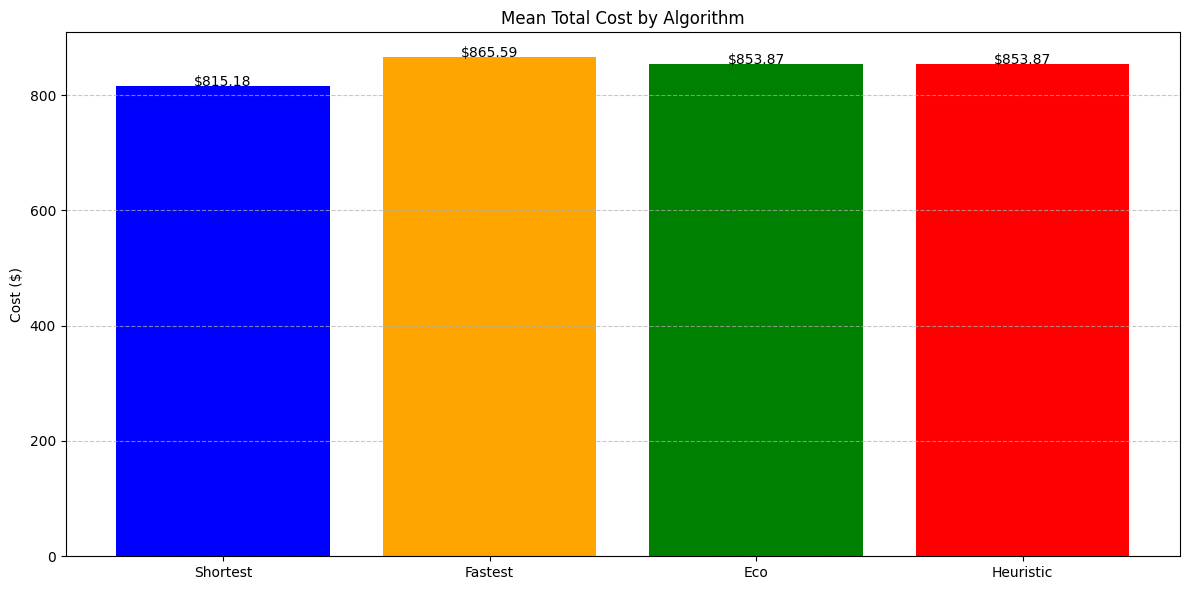

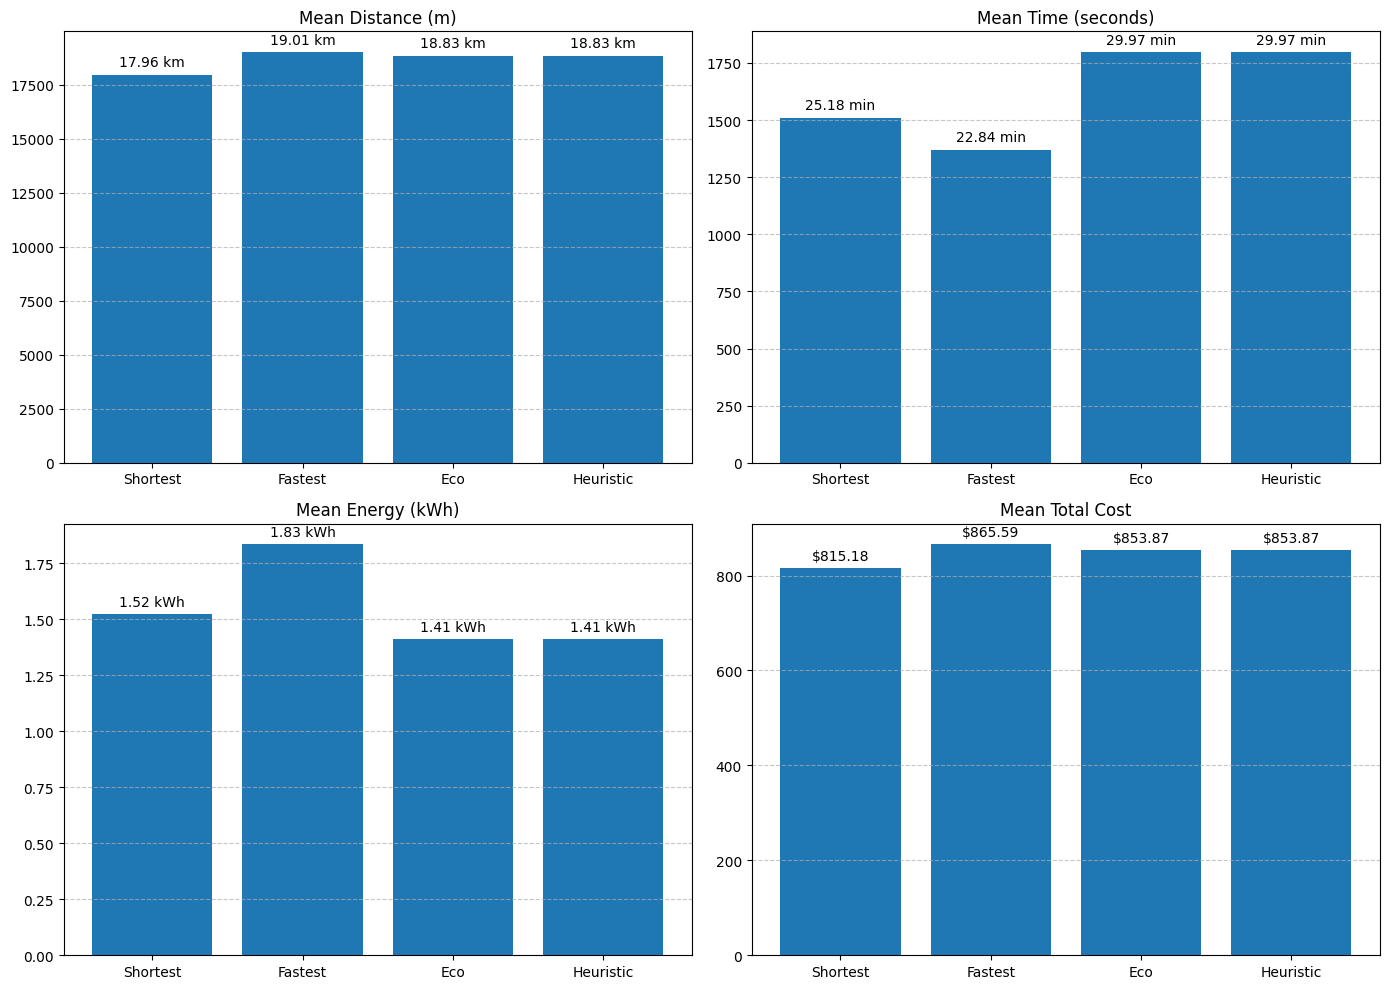


Evaluation complete!


In [71]:

results_df, summary_df = run_comprehensive_evaluation(num_od_pairs=50, min_distance=2000)